In [1]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path

sns.set(font_scale=1.6, style="ticks")

runs_folder = Path("../../../runs/cov_continents")
data_folder = Path("../../../data/gisaid/cov/spike_rbd_processed_continents")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)


/data/rbg/users/wxsh/miniconda3/envs/vaxseer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NLL & revNLL

In [2]:
testing_window=3
year_and_month_all = ("2021-07", "2021-10", "2022-01", "2022-04")
locations = ("africa", "asia", "europe", "north_america", "oceania", "south_america")

def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())
    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
    
    freqs = torch.mean(freqs, dim=1)
    freqs = freqs / torch.sum(freqs)
    
    if "token_num" in df:
        token_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy())
        token_num = torch.mean(token_num.float(), dim=1)
        nll = torch.sum(freqs * nlls) / torch.sum(freqs * token_num)
    else:
        nll = torch.sum(freqs * nlls)
    
    return nll


def read_all_nll(path, id2location):
    if isinstance(path, Path):
        if not os.path.exists(path):
            print(path)
            return None
        
        df = pd.read_csv(path)
        locations = []
        for src_id in df["src_id"]:
            locations.append(id2location[src_id])
        df["location"] = locations
        return df
    elif isinstance(path, dict):
        all_dfs = []
        for location, p in path.items(): 
            df = pd.read_csv(p)
            locations = [location] * len(df)
            df["location"] = locations
            all_dfs.append(df)
        return pd.concat(all_dfs)

time2location_to_count = dict()
id2location = dict()
id2count = defaultdict(int)

for year_and_month in year_and_month_all:
    year, month = year_and_month.split("-")
    year = int(year)
    
    testing_index = int((year - 2020) * 12 / testing_window + (int(month) + testing_window - 1) / testing_window)
    
    total_bin_size=0
    data_bin_size=0
    location_to_count = defaultdict(int)

    all_test_path=data_folder / f"2020-01_to_2023-12_{testing_window}M/all/human_minBinSize100_minLen223_maxLen223_location_region1_bins/{testing_index}.fasta"
    bin_size=int(next(SeqIO.parse(all_test_path, "fasta")).description.split("bin_size=")[1].split("|")[0])
    data_bin_size+=bin_size

    for record in SeqIO.parse(all_test_path, "fasta"):
        desc = record.description.split()[1].split("|")
        desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
        id2location[record.id] = desc["location"]
        id2count[record.id] += round(float(desc["freq"]) * int(desc["bin_size"]))

        location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))

    print("Total number of seqs:", sum(id2count.values()), data_bin_size, sum(location_to_count.values()))
    
    time2location_to_count[year_and_month] = location_to_count


Total number of seqs: 2630701 2630701 2630701
Total number of seqs: 5737917 3107216 3107216
Total number of seqs: 7270986 1533069 1533069
Total number of seqs: 8606214 1335228 1335228


In [3]:
nll_results = defaultdict(list)

for year_and_month in year_and_month_all:
    print(year_and_month)
    year, month = year_and_month.split("-")
    year = int(year)

    for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
        name2nll_path = {
                "Global": runs_folder / f"2019-12_to_{year_and_month}_1M/global/test_{testing_window}M/temp_{temperature}/test_results.csv",

                "Transmission (with reg)": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission/test_{testing_window}M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                "Transmission (no reg)": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission_ablation/no_reg/test_{testing_window}M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                "no reg, shuffle": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission_ablation/no_reg_shuffle/test_{testing_window}M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                "no reg, top-3 eig": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission_ablation/no_reg_top3_eig/test_{testing_window}M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                
            }
        model2nll = dict()
        for model in name2nll_path:
            model2nll[model] = read_all_nll(name2nll_path[model], id2location)
        for location in locations:

            for rev_nll_dir in ("test_rev_1", "test_rev_2", "test_rev_3"):

                name2rev_nll_path = {
                    "Global": runs_folder / f"2019-12_to_{year_and_month}_1M/global/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",

                    "Transmission (with reg)": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Transmission (no reg)": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission_ablation/no_reg/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "no reg, shuffle": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission_ablation/no_reg_shuffle/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "no reg, top-3 eig": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission_ablation/no_reg_top3_eig/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                }

                for name, _path in name2nll_path.items():
                    our_model_path_rev_nll = name2rev_nll_path[name]

                    if os.path.exists(our_model_path_rev_nll) and name in model2nll:
                        df = model2nll[name]
                        nll = get_nlls(df[df["location"] == location])
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["location"].append(location)
                        nll_results["model"].append(name)
                        nll_results["time"].append(year_and_month)
                        nll_results["bin_size"].append(time2location_to_count[year_and_month][location])
                        nll_results["oracle_model"].append(rev_nll_dir)


                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print(our_model_path_rev_nll)

                        if model not in model2nll:
                            print(model)

nll_results = pd.DataFrame(nll_results)
print(nll_results)


2021-07
2021-10
2022-01
2022-04
           NLL  reverse NLL  temperature       location  \
0     0.187725     0.028406          0.2         africa   
1     0.168698     0.006619          0.2         africa   
2     0.172710     0.006592          0.2         africa   
3     0.167823     0.008257          0.2         africa   
4     0.149115     0.006872          0.2         africa   
...        ...          ...          ...            ...   
1795  0.057070     0.028783          1.0  south_america   
1796  0.051576     0.030317          1.0  south_america   
1797  0.065467     0.042985          1.0  south_america   
1798  0.050586     0.039549          1.0  south_america   
1799  0.047902     0.028064          1.0  south_america   

                        model     time  bin_size oracle_model  
0                      Global  2021-07     25760   test_rev_1  
1     Transmission (with reg)  2021-07     25760   test_rev_1  
2       Transmission (no reg)  2021-07     25760   test_rev_1  
3  

In [4]:
def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df["NLL"]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df["reverse NLL"]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df["NLL"])
            ave_rev_nll = np.mean(_df["reverse NLL"])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results["nll"].append(ave_nll)
        summary_nll_results["rev_nll"].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))

    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    print(summary_nll_results)
    return summary_nll_results

In [5]:
local_summary_df = get_summary(nll_results, keys=("model", "temperature", "location", "oracle_model"))

                       model  temperature       location oracle_model  \
0                     Global          0.2         africa   test_rev_1   
1    Transmission (with reg)          0.2         africa   test_rev_1   
2      Transmission (no reg)          0.2         africa   test_rev_1   
3            no reg, shuffle          0.2         africa   test_rev_1   
4          no reg, top-3 eig          0.2         africa   test_rev_1   
..                       ...          ...            ...          ...   
445                   Global          1.0  south_america   test_rev_3   
446  Transmission (with reg)          1.0  south_america   test_rev_3   
447    Transmission (no reg)          1.0  south_america   test_rev_3   
448          no reg, shuffle          1.0  south_america   test_rev_3   
449        no reg, top-3 eig          1.0  south_america   test_rev_3   

          nll   rev_nll  toal_sample_size  
0    0.235997  0.019362             72208  
1    0.209985  0.013135            

                       model  temperature oracle_model       nll   rev_nll  \
0                     Global          0.2   test_rev_1  0.188012  0.016221   
1    Transmission (with reg)          0.2   test_rev_1  0.166250  0.015071   
2      Transmission (no reg)          0.2   test_rev_1  0.188315  0.012981   
3            no reg, shuffle          0.2   test_rev_1  0.174369  0.015498   
4          no reg, top-3 eig          0.2   test_rev_1  0.170368  0.013217   
..                       ...          ...          ...       ...       ...   
370                   Global          1.0   test_rev_3  0.045939  0.034812   
371  Transmission (with reg)          1.0   test_rev_3  0.041964  0.029273   
372    Transmission (no reg)          1.0   test_rev_3  0.046028  0.028183   
373          no reg, shuffle          1.0   test_rev_3  0.044427  0.036228   
374        no reg, top-3 eig          1.0   test_rev_3  0.042492  0.025212   

     toal_sample_size  
0             8606214  
1             8

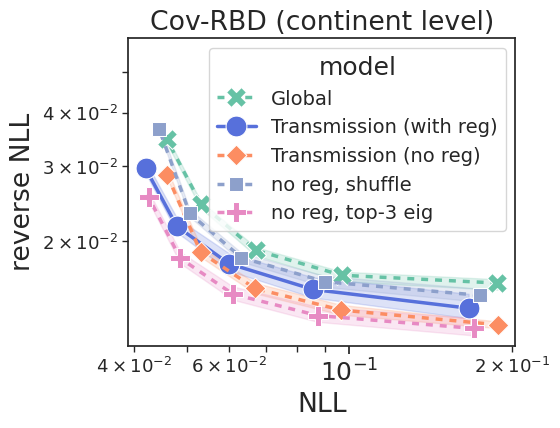

In [7]:
plt.xscale('log')
plt.yscale('log')
_nll_results = nll_results[nll_results["bin_size"] >= 5000]
summary_summary_df = get_summary(_nll_results, keys=("model", "temperature","oracle_model"), weighted_average=False)

plt.rcParams['lines.markersize'] = 10
plt.rcParams['figure.figsize'] = 5, 4

plt.rcParams['lines.markersize'] = 15

models = list(set(summary_summary_df["model"]))
models.sort()
style_dict = {}
for model in models:
    if model == "Transmission (with reg)":
        style_dict[model] = ""
    else:
        style_dict[model] = (2,2)
        
style_order = models
style_order.remove("Transmission (with reg)")
style_order = ["Transmission (with reg)"] + style_order

if "Transmission (no reg)" in style_order:
    style_order.remove("Transmission (no reg)")
    style_order = style_order + ["Transmission (no reg)"]

palette_light = sns.color_palette("Set2", n_colors=8) # pastel
palette_dark = sns.color_palette("hls", n_colors=8)
color_dict = {}
for i, model in enumerate(models):
    color_dict[model] = palette_light[i]
color_dict["Transmission (with reg)"] = palette_dark[5]

ax = sns.lineplot(summary_summary_df, x="nll", y="rev_nll", hue="model", markers=True, # marker='o', 
                  sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

ax.set_title("Cov-RBD (continent level)")
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=18)

ax.set_xlabel("NLL")
ax.set_ylabel("reverse NLL")
current_ylim = plt.gca().get_ylim()
plt.gca().set_ylim(current_ylim[0], current_ylim[1] + 0.02)
plt.legend(title="model",fontsize='14', title_fontsize='18')
plt.savefig(saving_dir / "ablation_cov_continent_average.pdf", format='pdf', bbox_inches='tight')

plt.show()